<a href="https://colab.research.google.com/github/Heffx/CNN/blob/master/Projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
# Conferindo se o CUDA esta disponivel

verificaGPU = torch.cuda.is_available()

if not verificaGPU:
  print('CUDA INDISPONIVEL, TREINANDO COM CPU')
else:
  print('CUDA DISPONIVEL, TREINANDO COM GPU')

CUDA DISPONIVEL, TREINANDO COM GPU


In [3]:
!pip3 install torchvision

In [0]:
# Fazendo download e descompactando o dataset
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

In [0]:
import json
import os
import flower_data
from torchvision import datasets
import torchvision
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import glob
import numpy as np
from skimage import data, io, filters


#Carregando, Normalizando e Criando vetor de Imagens

In [6]:
#Carregando treino com data loader


imagenet_train = torchvision.datasets.ImageFolder('flower_data/train/')

imagenet_valid = torchvision.datasets.ImageFolder('flower_data/valid/')
                                                 
                                                 
print(imagenet_train)
print(imagenet_valid)
data_loader_train = torch.utils.data.DataLoader(imagenet_train,
                                          batch_size=32,
                                          shuffle=True)

data_loader_valid = torch.utils.data.DataLoader(imagenet_valid,
                                          batch_size=32,
                                          shuffle=True)
                                          


print(data_loader_train)
print(data_loader_valid)



Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: flower_data/train/
    Transforms (if any): None
    Target Transforms (if any): None
Dataset ImageFolder
    Number of datapoints: 818
    Root Location: flower_data/valid/
    Transforms (if any): None
    Target Transforms (if any): None


In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    data_loader_train: transforms.Compose([
        # Redimensiona a imagem em (224,224)
        transforms.RandomResizedCrop(224),
        # Inverte horizontalmente a imagem
        transforms.RandomHorizontalFlip(),
        # Transforma em matriz de dados unicos
        transforms.ToTensor(),
        # Normaliza as imagens atraves de desvio padrão(Valores retirados de outro trabalho) 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    data_loader_valid: transforms.Compose([
        # Transformação da imagem para tamanho de entrada
        transforms.Resize(256),
        # Recorta a imagem no centro
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print(data_transforms)

{<torch.utils.data.dataloader.DataLoader object at 0x7fdcc23672e8>: Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), <torch.utils.data.dataloader.DataLoader object at 0x7fdcae2bfc18>: Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}


In [0]:
# Função que le as imagens
def read_images(path):
  classes = glob.glob(path + '*')
  # Recebe o nome de todos os arquivos
  im_files = []
  # Recebe a quantidade de todas as classes
  size_classes = []
  
  for i in classes:
    # Agrupa as imagens por classe
    name_images_per_class = glob.glob(i+ '/*')
    im_files = im_files+name_images_per_class
    # Agrupa a quantidade de cada classe no vetor size_class
    size_classes.append(len(name_images_per_class))
  # Agrupa as imagens e classe em uma matriz de zeros
  labels = np.zeros((len(im_files), len(classes)))
  ant = 0
  
  for id_i, i in enumerate(size_classes):
    labels[ant:ant+i, id_i] = 1
    ant = i
  # Carrega uma coleção de imagens
  collection = io.imread_collection(im_files)
  # Vetor de saída
  data = []
  
  for id_i, i in enumerate(collection):
    # Concatena no vetor data a matriz da imagem e o nome da imagem
    data.append((i, im_files[id_i]))
  return np.asarray(data) , np.asarray(labels)

In [0]:
# Load Train

# Chamada do vetor de imagens para treino
path = 'flower_data/train/'
data = []
labels = []
# Chamada da função que le as imagens
data, labels = read_images(path)

In [28]:
print(labels)
print(type(data))
print(data.shape)
print(labels.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'>
(6552, 2)
(6552, 102)


(500, 506, 3)

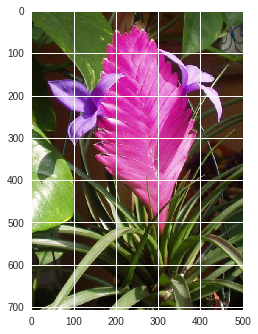

In [20]:
#Plotando uma das imagens
plt.imshow(data[6551][0], cmap = 'Greys_r')
data[0][0].shape

In [0]:
with open('cat_to_name.json', 'r') as f:
      labels_name = json.load(f)

In [32]:
print(labels_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

## Pre-treino